# Классификация пород кошек и собак по лицу

Импортируем необходимые библиотеки

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sn
import pandas as pd

from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

from pathlib import Path


Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [196]:
url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
dataset = Path(utils.get_file('petfaces', origin=url, untar=True))

img_size = 256, 256


## Обработка входных данных

### Разделение на обучающую и тестовую выборки


In [197]:
SEED = 2904

train = utils.image_dataset_from_directory(
    dataset, 
    validation_split=0.2, 
    subset='training', 
    seed=SEED,
    image_size=img_size,
    batch_size=32)

test = utils.image_dataset_from_directory(
    dataset, 
    validation_split=0.2, 
    subset='validation', 
    seed=SEED,
    image_size=img_size,
    batch_size=32)

class_names = train.class_names


Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


### Предобработка входных данных

In [198]:
cats, dogs = list(), list()

for i in range(len(class_names)):
    if class_names[i].startswith('cat'):
        cats.append(i)
    if class_names[i].startswith('dog'):
        dogs.append(i)

train = train.cache().shuffle(SEED//2).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


## Обучение модели

In [200]:
model = Sequential()

model.add(layers.RandomFlip("horizontal", input_shape=(img_size[0], img_size[1], 3)),)
model.add(layers.RandomRotation(0.1),)
model.add(layers.RandomZoom(0.1),)
model.add(layers.Conv2D(16, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(class_names)))
model.add(layers.Softmax())


In [201]:
top3_accuracy = SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', top3_accuracy])


In [202]:
# tf.config.list_physical_devices('GPU')
epochs = 32

history = model.fit(train, validation_data=test, epochs=epochs)

Epoch 1/32
81/81 [==============================] - 55s 649ms/step - loss: 19.4968 - accuracy: 0.0572 - top3_accuracy: 0.1534 - val_loss: 3.3033 - val_accuracy: 0.1231 - val_top3_accuracy: 0.2570
Epoch 2/32
81/81 [==============================] - 53s 648ms/step - loss: 3.2507 - accuracy: 0.1316 - top3_accuracy: 0.2795 - val_loss: 3.0064 - val_accuracy: 0.2134 - val_top3_accuracy: 0.3956
Epoch 3/32
81/81 [==============================] - 52s 644ms/step - loss: 3.0751 - accuracy: 0.1678 - top3_accuracy: 0.3643 - val_loss: 2.8834 - val_accuracy: 0.2259 - val_top3_accuracy: 0.4502
Epoch 4/32
81/81 [==============================] - 51s 632ms/step - loss: 2.9003 - accuracy: 0.2374 - top3_accuracy: 0.4352 - val_loss: 2.8829 - val_accuracy: 0.2321 - val_top3_accuracy: 0.4330
Epoch 5/32
81/81 [==============================] - 52s 637ms/step - loss: 3.0543 - accuracy: 0.1865 - top3_accuracy: 0.3632 - val_loss: 3.1019 - val_accuracy: 0.1604 - val_top3_accuracy: 0.3645
Epoch 6/32
81/81 [======

## Точность классификатора

### Метрики

#### Accuracy

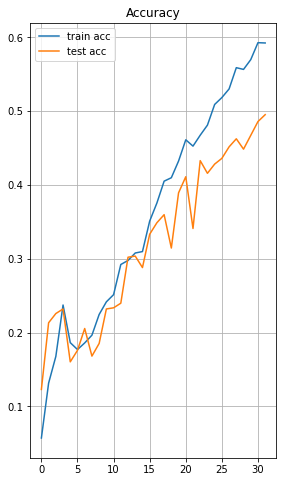

In [203]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(range(epochs), acc, label='train acc')
plt.plot(range(epochs), val_acc, label='test acc')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.show()

#### Loss

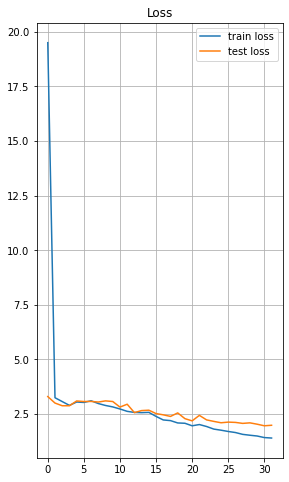

In [204]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(range(epochs), loss, label='train loss')
plt.plot(range(epochs), val_loss, label='test loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.show()


#### Top 3 accuracy

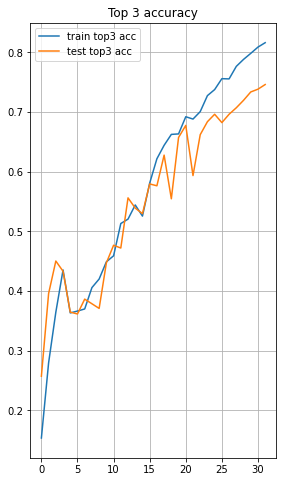

In [205]:
top3_acc = history.history['top3_accuracy']
val_top3_acc = history.history['val_top3_accuracy']

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(range(epochs), top3_acc, label='train top3 acc')
plt.plot(range(epochs), val_top3_acc, label='test top3 acc')
plt.legend()
plt.grid()
plt.title('Top 3 accuracy')

plt.show()


### Точность бинарной классификации

In [206]:
correct, total = 0, 0

for x, y in test:
    y_pred = np.argmax(model.predict(x), axis=1)
    correct_cats = sum([y_pred[i] in cats and y[i] in cats for i in range(len(y))])
    correct_dogs = sum([y_pred[i] in dogs and y[i] in dogs for i in range(len(y))])
    correct += correct_cats + correct_dogs
    total += len(y)

print('\nBinary classification accuracy: ', correct / total)


1/1 [==============================] - 0s 86ms/step

Binary classification accuracy:  0.8956386292834891


### Confusion matrix

1/1 [==============================] - 0s 37ms/step


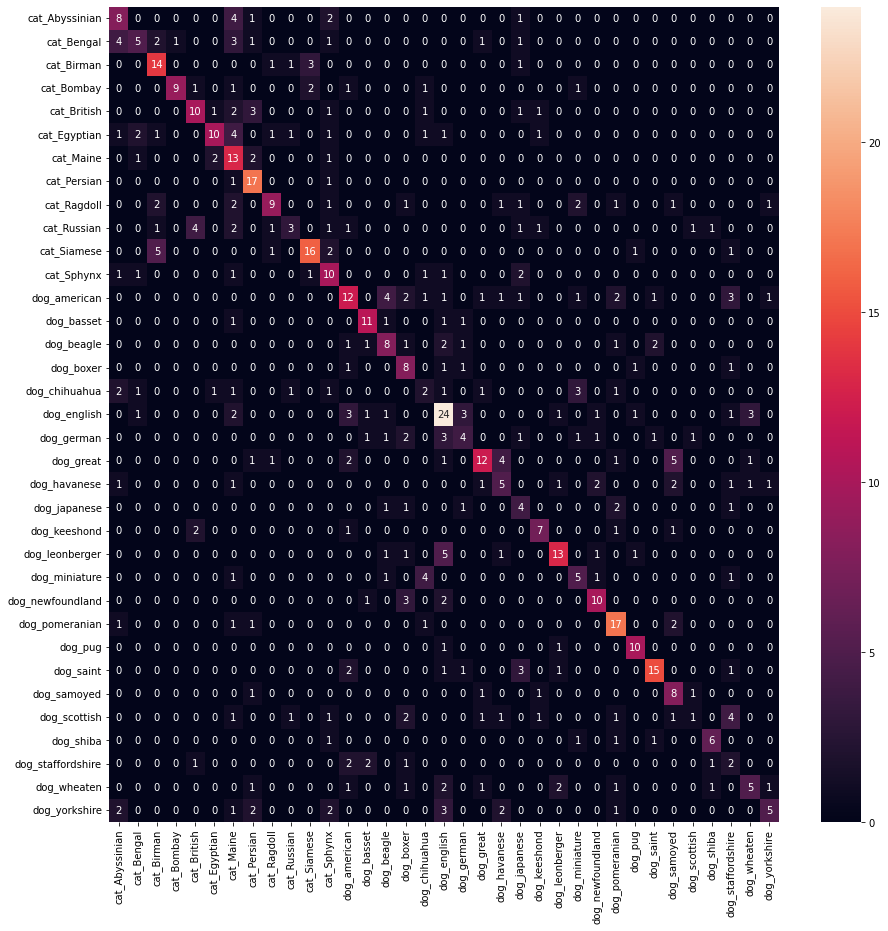

In [207]:
y_real = np.array([])
y_pred = np.array([])

for x, y in test:
    y_real = np.concatenate((y_real, y), axis=None)
    y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    

confusion_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=len(class_names))

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in class_names], columns = [i for i in class_names])

plt.figure(figsize = (15, 15))
sn.heatmap(df_cm, annot=True)
plt.show()
